In [1]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from tqdm import tqdm
import os

In [2]:
def draw_graph(nodes, edges, adj_list, positions=list(), axis=False, node_size=3):
    '''
    Draws graph with given nodes and edges. 

    Args:
        nodes (iterable)    :   node values
        edges (iterable)    :   edge values
        adj_list (iterable) :   adjacency list (not to be confused with adjacency matrix), shape=[number of edges, 2]
                                e.g adj_list[i] = (j, k) -> i-th edge (in edges) connects node j with node k (in nodes)
    
    Optional args:
        positions (iterable)    : shape=[number of nodes, 2], positions[i] = (x, y) -> x,y-positition of node i (in nodes)
        axis (bool)             : if True, plots axis (default: False)
        node_size (float)       : size of nodes in plot (default: 3)
    
    Todo:
        Introduce colorbar for node/edge values (currently, node/edge values are ignored)
    '''

    num_nodes = len(nodes)
    pos_given = len(positions)>0
    if pos_given and num_nodes != len(positions):
        print("Error: len(nodes) != len(positions)")
        return
    
    num_edges = len(edges)
    if num_edges != len(adj_list):
        print("Error: len(edges) != len(adj_list)")
        return

    G = nx.Graph()
    for n in range(num_nodes):
        if pos_given:
            G.add_node(n, n_value=nodes[n], pos=positions[n])
        else:
            G.add_node(n, n_value=nodes[n])
    for e in range(num_edges):
        G.add_edge(adj_list[e][0], adj_list[e][1], e_value=edges[e])

    pos_nodes =nx.get_node_attributes(G,'pos')

    if axis:
        fig = plt.figure()
        ax = fig.add_subplot()
        if pos_given:
            nx.draw(G, pos=pos_nodes, ax=ax, node_size=node_size)
        else:
            nx.draw(G, ax=ax, node_size=node_size)
        ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
        plt.axis('on')
    else:
        if len(positions)>0:
            nx.draw(G, pos=pos_nodes, node_size=node_size)
        else:
            nx.draw(G, node_size=node_size)

In [ ]:
def genLattice(len_ex, len_ey, theta, nx_max=20, ny_max=20, hexagonal=False, remove_center=False):
    '''
    Generates Bravais-lattice (https://en.wikipedia.org/wiki/Bravais_lattice). 

    Args:
        len_ex (float)      :   length of first unit vector 
        len_ey (float)      :   length of second unit vector
        theta (float)       :   specifies the angle between first and second unit vector
    
    Optional args:
        nx_max (int)            :   number of nodes in x-direction (direction of the first unit vector), default: 20
        ny_max (int)            :   number of nodes in y-direction (direction of the second unit vector), default: 20
        hexagonal (bool)        :   if True, add additional diagonal edges so that the lattice becomes hexagonal, default:  False, i.e. rectangular lattice   
        remove_center (bool)    :   if True, removes center node of unit cell (results in honeycomb lattice), default: False

    Returns:
        num_nodes (int)     :   number of nodes
        num_edges (int)     :   number of edges
        adj_list (iterable) :   adjacency list (see also draw_graph()), shape=[num_edges, 2]
        pos (iterable)      :   nodes positions, shape=[num_nodes, 2] 
                                pos[i] gives the position of node i, nodes are numbered as follows:
                                    8   9   ....
                                    4   5   6   7
                                    0   1   2   3

    Todo:
        explain code, comment a few things
    '''
    
    e_x = len_ex*np.array([1, 0], dtype=float)
    e_y = len_ey*np.array([np.cos(theta), np.sin(theta)], dtype=float)
    num_nodes = nx_max*ny_max

    #indices
    ind_pos = np.zeros(shape=(num_nodes, 2), dtype=int)
    ind_pos[:, 0] = np.tile(np.arange(0, nx_max), ny_max)
    ind_pos[:, 1] = np.array([nx_max*[y] for y in range(ny_max)]).flatten()

    #positions
    pos = np.zeros(shape=(num_nodes, 2), dtype=float)
    for n in range(num_nodes):
        pos[n, :] = ind_pos[n, 0]*e_x + ind_pos[n, 1]*e_y

    #edges, adj_list
    adj_list = np.array([], dtype=int)
    num_edges = 0

    if hexagonal==True:
        num_edges = ny_max*(nx_max - 1) + nx_max*(ny_max - 1) + (nx_max-1)*(ny_max-1)
        adj_list = np.zeros(shape=(num_edges, 2), dtype=int)
        ind_edge = 0
        for x in range(0, nx_max):
            for y in range(0, ny_max):
                ind_center = y*nx_max + x
                ind = [ind_center, ind_center + nx_max, ind_center + 1, ind_center + nx_max + 1] #center, up, right, diag
                edge_possible = [True, True, True] #up, right
                if x == nx_max - 1:
                    edge_possible[1] = False
                    edge_possible[2] = False
                if y == ny_max - 1:
                    edge_possible[0] = False
                    edge_possible[2] = False
                for dir in range(3):
                    if edge_possible[dir]:
                        adj_list[ind_edge] = [ind[0], ind[dir + 1]]
                        ind_edge += 1
    else:
        num_edges = ny_max*(nx_max - 1) + nx_max*(ny_max - 1)
        adj_list = np.zeros(shape=(num_edges, 2), dtype=int)
        ind_edge = 0
        for x in range(0, nx_max):
            for y in range(0, ny_max):
                ind_center = y*nx_max + x
                ind = [ind_center, ind_center + nx_max, ind_center + 1] #center, up, right
                edge_possible = [True, True] #up, right
                if x == nx_max - 1:
                    edge_possible[1] = False
                if y == ny_max - 1:
                    edge_possible[0] = False
                for dir in range(2):
                    if edge_possible[dir]:
                        adj_list[ind_edge] = [ind[0], ind[dir + 1]]
                        ind_edge += 1
    
    if remove_center:
        pos_to_remove = list()
        for x in range(0, nx_max):
            y_off = (3-x) % 3
            for y in range(y_off, ny_max, 3):
                pos_to_remove.append([x, y])

                
        ind_to_remove = list([pos[0] + pos[1]*nx_max for pos in pos_to_remove])
        mask = np.array([i in ind_to_remove for i in range(num_nodes)]) #True if element should be removed
        mask_edges = np.array([((e[0] in ind_to_remove) or (e[1] in ind_to_remove)) for e in adj_list]) #True if edge should be removed

        adj_list = adj_list[~mask_edges]
        num_edges -= np.count_nonzero(mask_edges)
        num_nodes -= np.count_nonzero(mask)

        for e in adj_list: #shift (deleting nodes = indices of nodes change)
            e[0] -= np.count_nonzero(mask[:e[0]])
            e[1] -= np.count_nonzero(mask[:e[1]])
            
        pos = pos[~mask]
    
    return num_nodes, num_edges, adj_list, pos

In [36]:
def addNoise(arr, mu, sigma, scale):
    '''
    Adds normal distributed noise to positions.
    
    Args:
        arr (iterable)  :   array on which values noise is added (shape is arbitrary)
        mu (float)      :   mean value of normal distributed noise
        sigma (float)   :   standard deviation
        scale (float)   :   scaling factor   
    
    Returns:
        arr_ (iterable) :   noisy positions
    '''
    
    arr_ = arr + scale*np.random.normal(mu, sigma, size=arr.shape)
    return arr_

In [37]:
def rotateLattice(pos, alpha):
    '''
    Rotates position by alpha degress around origin.
    
    Args:
        pos (iterable)  :   shape=[-1, 2], shape[i] = (x, y)
        alpha (float)   :   angle (in radians)
    
    Returns:
        pos_ (iterable) :   rotated positions
        
    Todo:
        WTF?! completely broken
    '''
    
    rotMat = np.array(
        [[np.cos(alpha), -np.sin(alpha)], 
        [np.sin(alpha), np.cos(alpha)]])
    pos_ = np.zeros(shape=pos.shape)
    for i in range(len(pos)):
        pos_[i, :] = np.matmul(rotMat, pos[i, :])
    return pos_

In [38]:
def undirectGraph(adj_list):
    '''
    Undirects graph: adds for each edge (i,j) in the adjancency list a new edge (j,i) (i.e. going in the opposite direction).

    Args:
        adj_list (iterable) :   directed adjacency list, shape=[num_edges, 2]
    
    Returns:
        num_edges (int)                 :   number of edges (twice the number of edges in the directed graph)
        adj_list_undirected (iterable)  :   undirected adjacency list, shape=[2*num_edges, 2]
    
    Todo:
        delete duplicate edges
    '''

    num_edges = len(adj_list)
    adj_list_undirected = np.zeros(shape=(2*num_edges, 2), dtype=int)
    adj_list_undirected[:num_edges, :] = adj_list
    adj_list_undirected[num_edges:, :] = np.flip(adj_list, axis=1)
    return 2*num_edges, adj_list_undirected
    

In [39]:
def saveLattice(filename, nodes, edges, adj_list, label, positions=list()):
    '''
    Saves lattice to .npz file.
    
    Args:
        filename (string)   :   file to save to
        nodes (iterable)    :   node values
        edges (iterable)    :   edge values
        adj_list (iterable) :   adjacency list (see also draw_graph()), shape=[number of edges, 2]
        label (iterable)    :   label (can later be used for classifying the graph), shape is arbitrary
                                e.g. if the graphs should be classified in distinct categories, then label=[i] (i represents category), would be a reasonable choice 

    Optional args:
        positions (iterable)    :   nodes positions, if empty, no positions will be stored, default: empty
    '''

    if len(positions) > 0:
        if len(positions)!=len(nodes):
           print("Error: len(positions) != len(nodes)")
           return
        np.savez(filename, nodes=nodes, edges=edges, adj_list=adj_list, label=label, positions=positions)
    else:
        if len(edges)!=len(adj_list):
            print("Error: len(edges) != len(adj_list)")
            return 
        np.savez(filename, nodes=nodes, edges=edges, label=label, adj_list=adj_list)

In [40]:
def countNeighbors(adj_list, node_index):
    '''
    Computes the number of nearest neighbors of one specific node. 
    Attention: If (node_index, j) is in the adjacency list, then j is regarded as a neighbor. 
    However, if (j, node_index) is in the adjacency list, then j is not regarded as a neighbor.

    Args:
        adj_list (iterable) :   adjacency list, shape=[number of nodes, 2]
        node_index (int)    :   the node index to look at
    
    Return:
        num_neighbors (int) :   number of neighbors of node with indes node_index
    '''
    num_neighbors = 0
    for edge in adj_list:
        if edge[0] == node_index:
            num_neighbors += 1
    return num_neighbors

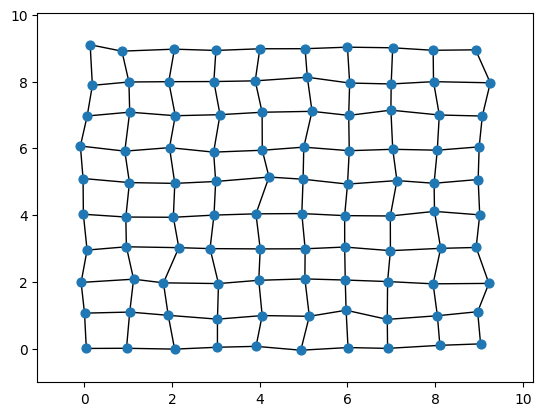

In [43]:
num_nodes, num_edges, adj_list, pos = genLattice(1, 1, np.pi/2, nx_max=10, ny_max=10)
pos = addNoise(pos, 0, 0.5, 0.15)
node_values = np.zeros(shape=(num_nodes, ))
edge_values = np.zeros(shape=(num_edges, ))
draw_graph(node_values, edge_values, adj_list, pos, axis=True, node_size=40)

In [47]:
# generate 200 graphs for each lattice type 
# lattice types: 0 = square, 1 = rectangular, 2 = hexagonal, 3 = oblique 
def rand(mean, scale_off):
    r = np.random.rand() #random samples from uniform distribution in [0,)
    r = 2*r - 1 #in [-1, 1)
    return mean + scale_off*r

N = 1000
off_len = 0.1
mu = 0
sigma = 0.5
scale = 0.15

# 0 = square
print("square lattice...")
if not os.path.isdir("squares"):
    os.mkdir("squares")
for i in tqdm(range(N)):
    label = np.array([[1, 0, 0, 0]])
    len_ex = rand(5, 2)
    theta = rand(np.pi/2, 2*np.pi/180)
    num_nodes, num_edges, adj_list, pos = genLattice(rand(len_ex, off_len), rand(len_ex, off_len), theta, nx_max=10, ny_max=10)
    pos = addNoise(pos, mu, sigma, scale)
    num_edges, adj_list = undirectGraph(adj_list)

    values_nodes = np.zeros(shape=(num_nodes, 4)) #shape=[num_nodes, num_node_features]
    values_edges = np.zeros(shape=(num_edges, 2)) #shape=[num_edges, num_edge_features]
    for e in range(num_edges):
        values_edges[e, :] = pos[adj_list[e, 1]] - pos[adj_list[e, 0]]
    for n in range(num_nodes):
        values_nodes[n, :] = countNeighbors(adj_list, n)

    saveLattice(f"squares/square_{i}.npz", values_nodes, values_edges, adj_list, label, pos)   

# 1 = rectangular
print("rectangular lattice...")
if not os.path.isdir("rectangles"):
    os.mkdir("rectangles")
for i in tqdm(range(N)):
    label = np.array([[0, 1, 0, 0]])
    len_ex = rand(5, 2)
    len_ey = rand(10, 2)
    theta = rand(np.pi/2, 2*np.pi/180)
    num_nodes, num_edges, adj_list, pos = genLattice(rand(len_ex, off_len), rand(len_ey, off_len), theta, nx_max=10, ny_max=10)
    pos = addNoise(pos, mu, sigma, scale)
    num_edges, adj_list = undirectGraph(adj_list)

    values_nodes = np.zeros(shape=(num_nodes, 4))
    values_edges = np.zeros(shape=(num_edges, 2))
    for e in range(num_edges):
        values_edges[e, :] = pos[adj_list[e, 1]] - pos[adj_list[e, 0]]
    for n in range(num_nodes):
        values_nodes[n, :] = countNeighbors(adj_list, n)

    saveLattice(f"rectangles/rectangular_{i}.npz", values_nodes, values_edges, adj_list, label, pos)   

# 2 = hexagonal
print("hexagonal lattice...")
if not os.path.isdir("hexagons"):
    os.mkdir("hexagons")
for i in tqdm(range(N)):
    label = np.array([[0, 0, 1, 0]])
    len_ex = rand(5, 2)
    theta = rand(2*np.pi/3, 2*np.pi/180)
    num_nodes, num_edges, adj_list, pos = genLattice(rand(len_ex, off_len), rand(len_ex, off_len), theta, nx_max=10, ny_max=10, hexagonal=True)
    pos = addNoise(pos, mu, sigma, scale)
    num_edges, adj_list = undirectGraph(adj_list)

    values_nodes = np.zeros(shape=(num_nodes, 4))
    values_edges = np.zeros(shape=(num_edges, 2))
    for e in range(num_edges):
        values_edges[e, :] = pos[adj_list[e, 1]] - pos[adj_list[e, 0]]
    for n in range(num_nodes):
        values_nodes[n, :] = countNeighbors(adj_list, n)

    saveLattice(f"hexagons/hexagonal_{i}.npz", values_nodes, values_edges, adj_list, label, pos)   

# 3 = oblique
print("oblique lattice...")
if not os.path.isdir("oblique"):
    os.mkdir("oblique")
for i in tqdm(range(N)):
    label = np.array([[0, 0, 0, 1]])
    len_ex = rand(5, 2)
    len_ey = rand(10, 2)
    theta = rand(np.pi/4, 30*np.pi/180) #45 Grad pm 30 Grad
    num_nodes, num_edges, adj_list, pos = genLattice(rand(len_ex, off_len), rand(len_ey, off_len), theta, nx_max=10, ny_max=10)
    pos = addNoise(pos, mu, sigma, scale)
    num_edges, adj_list = undirectGraph(adj_list)

    values_nodes = np.zeros(shape=(num_nodes, 4)) 
    values_edges = np.zeros(shape=(num_edges, 2))
    for e in range(num_edges):
        values_edges[e, :] = pos[adj_list[e, 1]] - pos[adj_list[e, 0]]
    for n in range(num_nodes):
        values_nodes[n, :] = countNeighbors(adj_list, n)

    saveLattice(f"oblique/oblique_{i}.npz", values_nodes, values_edges, adj_list, label, pos)   

print("Done")

square lattice...


100%|██████████| 1000/1000 [00:13<00:00, 72.73it/s]


rectangular lattice...


100%|██████████| 1000/1000 [00:12<00:00, 79.27it/s]


hexagonal lattice...


100%|██████████| 1000/1000 [00:13<00:00, 71.89it/s]


oblique lattice...


100%|██████████| 1000/1000 [00:12<00:00, 82.06it/s]

Done


KeysView(NpzFile 'hexagons/hexagonal_101.npz' with keys: nodes, edges, adj_list, label, positions)
label:  [[0 0 1 0]]


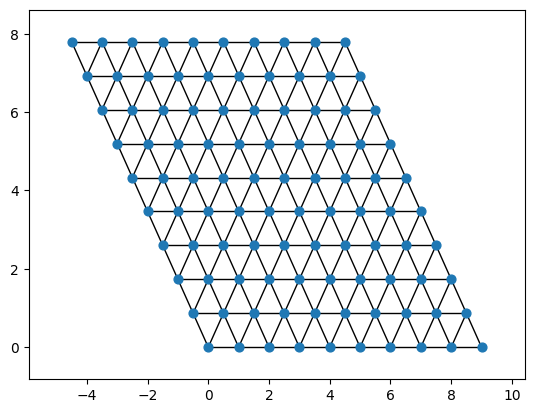

In [17]:
# quick check that generation works
graph = np.load("hexagons/hexagonal_101.npz")
print(graph.keys())
print("label: ", graph["label"])
node_values = graph["nodes"]
edge_values = graph["edges"]
adj_list = graph["adj_list"]
pos = graph["positions"]
draw_graph(node_values, edge_values, adj_list, pos, axis=True, node_size=40)

In [31]:
np.random.rand()

0.5692541786835899